# Оценка стоимости автомобиля

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нем можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нам нужно построить модель для определения стоимости. 

Заказчику важны:
- качество предсказания;
- скорость предсказания;
- время обучения.


Требования к качеству: RMSE должна быть не больше 2500.

## Содержание<a name="Содержание"></a>

1. [Знакомство с данными](#1.-Знакомство-с-данными)
2. [Предобработка данных](#2.-Предобработка-данных)
	1. [Удаление признаков, не описывающих автомобиль](#Удаление-признаков,-не-описывающих-автомобиль)
	2. [Обработка пропусков](#Обработка-пропусков)
	3. [Замена типа данных](#Замена-типа-данных)
	4. [Поиск дубликатов](#Поиск-дубликатов)
3. [Подготовка данных к обучению](#3.-Подготовка-данных-к-обучению)
	1. [Обработка выбросов](#Обработка-выбросов)
	2. [Порядковое кодирование категориальных признаков](#Порядковое-кодирование-категориальных-признаков)
	3. [Разбиение данных на выборки](#Разбиение-данных-на-выборки)
	4. [Масштабирование численных признаков](#Масштабирование-численных-признаков)
4. [Обучение моделей](#4.-Обучение-моделей)
	1. [Линейная регрессия](#Линейная-регрессия)
	2. [Случайный лес](#Случайный-лес)
	3. [Стохастический градиентный спуск](#Стохастический-градиентный-спуск)
	4. [Градиентный бустинг](#Градиентный-бустинг)
5. [Сравнение моделей](#5.-Сравнение-моделей)
	1. [Градиентный бустинг и линейные модели](#Градиентный-бустинг-и-линейные-модели)
	2. [Случайный лес и время предсказаний](#Случайный-лес-и-время-предсказаний)
	3. [Вывод](#Вывод)
6. [Предсказание для тестовой выборки](#6.-Предсказание-для-тестовой-выборки)

## 0. Импорт библиотек

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from lightgbm import LGBMRegressor

In [2]:
pd.options.mode.chained_assignment = None
sns.set_style('darkgrid')

In [3]:
SEED = 42

## 1. Знакомство с данными<a name="1.-Знакомство-с-данными"></a>

Сохраним данные в переменную `autos` и посмотрим на общую информацию.

In [4]:
autos = pd.read_csv('autos.csv')

In [5]:
print('\033[1m' + 'Случайные строки из таблицы' + '\033[0m')
display(autos.sample(5))

Случайные строки из таблицы


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
335568,2016-03-25 20:56:07,8200,small,2007,manual,120,cooper,100000,10,petrol,mini,no,2016-03-25 00:00:00,0,45711,2016-04-07 03:17:46
95399,2016-03-08 09:53:11,1900,bus,2003,manual,86,transit,150000,12,gasoline,ford,no,2016-03-08 00:00:00,0,49584,2016-04-07 12:15:22
287659,2016-03-27 21:54:15,3400,sedan,1998,manual,102,a4,150000,6,petrol,audi,no,2016-03-27 00:00:00,0,38226,2016-04-05 21:15:40
194724,2016-03-16 21:46:07,850,small,2000,manual,69,2_reihe,150000,10,gasoline,peugeot,no,2016-03-16 00:00:00,0,77815,2016-03-17 20:46:19
129272,2016-03-25 09:57:41,2850,NaN,2017,manual,90,NaN,150000,9,petrol,mini,no,2016-03-25 00:00:00,0,56249,2016-03-26 22:29:30


Каждый объект в `autos` — это информация о технических характеристиках, комплектации и цене одного из ранее проданных автомобилей. А именно:

- *DateCrawled* — дата скачивания анкеты из базы;
- *VehicleType* — тип автомобильного кузова;
- *RegistrationYear* — год регистрации автомобиля;
- *Gearbox* — тип коробки передач;
- *Power* — мощность (л. с.);
- *Model* — модель автомобиля;
- *Kilometer* — пробег (км);
- *RegistrationMonth* — месяц регистрации автомобиля;
- *FuelType* — тип топлива;
- *Brand* — марка автомобиля;
- *NotRepaired* — была машина в ремонте или нет;
- *DateCreated* — дата создания анкеты;
- *NumberOfPictures* — количество фотографий автомобиля;
- *PostalCode* — почтовый индекс владельца анкеты (пользователя);
- *LastSeen* — дата последней активности пользователя.

Целевой признак — *Price*. Это цена авто в евро.

In [6]:
print('\033[1m' + 'Общие сведения о данных' + '\033[0m')
autos.info()

Общие сведения о данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
d

Проблемы, которые мы обнаружили:
1. У признаков неправильные типы: у дат строковый тип, а у численных можно понизить размерность.
2. Есть признаки, которые не влияют на цену автомобиля. А именно:
    - *DateCrawled* — дата скачивания анкеты из базы;
    - *RegistrationMonth* — месяц регистрации автомобиля;
    - *DateCreated* — дата создания анкеты;
    - *NumberOfPictures* — количество фотографий автомобиля;
    - *PostalCode* — почтовый индекс владельца анкеты (пользователя);
    - *LastSeen* — дата последней активности пользователя.
3. В данных есть пропуски. Изучим их подробнее позже.

In [7]:
print('\033[1m' + 'Числовое описание данных' + '\033[0m')
autos.describe()

Числовое описание данных


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Наблюдения:
1. У признаков разный масштаб — придется стандартизировать.
2. По максимумам некоторых признаков, например году регистрации, видны выбросы. Более глубоко исследуем их позже.
3. Странно, что в пробеге и медиана, и третий квантиль, и максимум равны 150 тысячам километров. Возможно, это максимальное число, доступное для ввода, или у нас какой-то баг в базе данных.

[К содержанию](#Содержание)

## 2. Предобработка данных<a name="2.-Предобработка-данных"></a>

### Удаление признаков, не описывающих автомобиль<a name="Удаление-признаков,-не-описывающих-автомобиль"></a>

Начнем с простого — избавимся от признаков, которые не относятся к характеристикам автомобиля. Это:
- дата скачивания объявления из базы,
- дата создания объявления,
- количество фотографий автомобиля в объявлении,
- почтовый индекс продавца,
- месяц регистрации автомобиля.

Мы оставим в признаках год регистрации автомобиля, так как он может отражать возраст машины.

Будем хранить очищенные данные в новой переменной `autos_clean`. Поместим в нее только нужные признаки из `autos` и посмотрим на результат.

In [8]:
autos_clean = autos.drop(columns=['DateCrawled', 'RegistrationMonth', 'DateCreated',
                                  'NumberOfPictures', 'PostalCode', 'LastSeen'])
autos_clean.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


### Обработка пропусков<a name="Обработка-пропусков"></a>

Посмотрим, в каких колонках есть пропуски и сколько их.

In [9]:
gaps = {'Число пропусков': autos_clean.isna().sum(),
        'Процент от всех значений': round(autos_clean.isnull().sum() / len(autos_clean) * 100, 2)}

gaps = pd.DataFrame(gaps)
gaps

,Число пропусков,Процент от всех значений
Price,0,0.00
VehicleType,37490,10.58
RegistrationYear,0,0.00
Gearbox,19833,5.60
Power,0,0.00
Model,19705,5.56
Kilometer,0,0.00
FuelType,32895,9.28
Brand,0,0.00
NotRepaired,71154,20.08


Видно, что пропусков достаточно много, особенно в столбце `NotRepaired`. Но, что важнее, все пропуски находятся в категориальных переменных. Чтобы решить, как их заполнять, посмотрим на пропуски подробнее.

In [10]:
cat_cols_w_gaps = []

for index, row in gaps.iterrows():
    if row['Число пропусков'] > 0:
        cat_cols_w_gaps.append(index)
        print('\033[1m' + index + '\033[0m')
        print(autos_clean[index].value_counts())
        print()

VehicleType
sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: VehicleType, dtype: int64

Gearbox
manual    268251
auto       66285
Name: Gearbox, dtype: int64

Model
golf                  29232
other                 24421
3er                   19761
polo                  13066
corsa                 12570
                      ...  
i3                        8
serie_3                   4
rangerover                4
range_rover_evoque        2
serie_1                   2
Name: Model, Length: 250, dtype: int64

FuelType
petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

NotRepaired
no     247161
yes     36054
Name: NotRepaired, dtype: int64



Категорий много, особенно моделей машин, поэтому заполним пропуски значением `unknown`.

In [11]:
autos_clean[cat_cols_w_gaps] = autos_clean[cat_cols_w_gaps].fillna('unknown')

### Замена типа данных<a name="Замена-типа-данных"></a>

Теперь понизим размерность численных переменных и посмотрим на результат замен.

In [12]:
num_cols = autos_clean.select_dtypes(include='int').columns
for col in num_cols:
    autos_clean[col] = pd.to_numeric(autos_clean[col], downcast='unsigned')

In [13]:
autos_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354369 non-null  uint16
 1   VehicleType       354369 non-null  object
 2   RegistrationYear  354369 non-null  uint16
 3   Gearbox           354369 non-null  object
 4   Power             354369 non-null  uint16
 5   Model             354369 non-null  object
 6   Kilometer         354369 non-null  uint32
 7   FuelType          354369 non-null  object
 8   Brand             354369 non-null  object
 9   NotRepaired       354369 non-null  object
dtypes: object(6), uint16(3), uint32(1)
memory usage: 19.6+ MB


### Поиск дубликатов<a name="Поиск-дубликатов"></a>

Посмотрим, есть ли в данных дубликаты.

In [14]:
print('\033[1m' + 'Дубликаты' + '\033[0m')
print('Количество:', autos_clean.duplicated().sum())
print('Процент от всех записей:',
      round(autos_clean.duplicated().sum() / len(autos_clean) * 100, 2))

Дубликаты
Количество: 45040
Процент от всех записей: 12.71


In [15]:
autos_clean.columns

Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'FuelType', 'Brand', 'NotRepaired'],
      dtype='object')

Дубликатов на удивление много. Возможно, проблемы не в текущих признаках объявлений, а в тех, что мы удалили.

Например, объявление могло попасть в выборку несколько раз с разной датой добавления `DateCrawled`. Или сломалась запись времени последнего визита `LastSeen` пользователя и вместо одной записи в таблицу попало несколько. 

Разобраться, в чем проблема, — отдельная задача. Стоит рассказать о нашем открытии дата-инженерам, чтобы они узнали, что случилось.

Пока же просто избавимся от дубликатов.

In [16]:
autos_clean = autos_clean.drop_duplicates()

In [17]:
print('Количество дубликатов:', autos_clean.duplicated().sum())

Количество дубликатов: 0


[К содержанию](#Содержание)

## 3. Подготовка данных к обучению<a name="3.-Подготовка-данных-к-обучению"></a>

### Обработка выбросов<a name="Обработка-выбросов"></a>

Посмотрим еще раз на числовое описание данных.

In [18]:
autos_clean.describe()

,Price,RegistrationYear,Power,Kilometer
count,309329.000000,309329.000000,309329.000000,309329.000000
mean,4486.937196,2004.360105,110.976908,127217.735809
std,4564.852796,92.541399,200.969473,38532.941010
min,0.000000,1000.000000,0.000000,5000.000000
25%,1100.000000,1999.000000,69.000000,125000.000000
50%,2800.000000,2003.000000,105.000000,150000.000000
75%,6500.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


#### Цена

Мы не будем удалять выбросы из этого признака, потому что большой разброс цен не выглядит странно. Машина может стоить дорого, если это представительский класс или кастомная сборка. Низкой и даже нулевой цена может быть, если автомобиль в плохом состоянии или не на ходу и отдается на детали.

#### Год регистрации

Здесь все просто: удалим все строки, в которых год меньше даты изобретения первого автомобиля ([1768](https://ru.wikipedia.org/wiki/%D0%98%D1%81%D1%82%D0%BE%D1%80%D0%B8%D1%8F_%D0%B0%D0%B2%D1%82%D0%BE%D0%BC%D0%BE%D0%B1%D0%B8%D0%BB%D1%8F#:~:text=%D0%90%D0%B2%D1%82%D0%BE%D0%BC%D0%BE%D0%B1%D0%B8%D0%BB%D1%8C%20%D0%91%D0%B5%D0%BD%D1%86%D0%B0%2C%201885%20%D0%B3%D0%BE%D0%B4.,%D0%B0%D0%B2%D1%82%D0%BE%D0%BC%D0%BE%D0%B1%D0%B8%D0%BB%D1%8C%20%D1%81%20%D0%B4%D0%B2%D0%B8%D0%B3%D0%B0%D1%82%D0%B5%D0%BB%D0%B5%D0%BC%20%D0%B2%D0%BD%D1%83%D1%82%D1%80%D0%B5%D0%BD%D0%BD%D0%B5%D0%B3%D0%BE%20%D1%81%D0%B3%D0%BE%D1%80%D0%B0%D0%BD%D0%B8%D1%8F)) и больше текущего 2021-го. Но сначала посмотрим, сколько их.

In [19]:
print('Число автомобилей с аномальным годом регистрации:',
      len(autos_clean.query('RegistrationYear < 1768 or RegistrationYear > 2021')))

print('Процент автомобилей с аномальным годом регистрации от общего числа:',
      round(len(autos_clean.query('RegistrationYear < 1768 or RegistrationYear > 2021')) / len(autos_clean) * 100, 2))

Число автомобилей с аномальным годом регистрации: 158
Процент автомобилей с аномальным годом регистрации от общего числа: 0.05


Таких машин сильно меньше одного процента. Отлично!

In [20]:
autos_clean = autos_clean.query('RegistrationYear > 1768 and RegistrationYear < 2021')

#### Мощность

Здесь точно есть выбросы, от которых придется избавляться: максимальная мощность 20 тысяч лошадиных сил, в то время как у самого мощного серийного автомобиля только [2 тысячи](https://www.autonews.ru/news/5dcab2409a7947da1459c059).

Чтобы определить граничные значения, посмотрим на диаграмму размаха.

(0.0, 300.0)

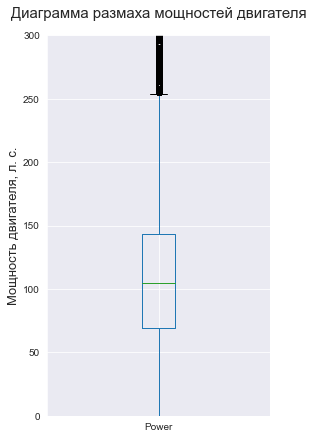

In [21]:
plt.figure(figsize=(4, 7))
autos_clean.boxplot('Power')

plt.title('Диаграмма размаха мощностей двигателя', fontsize=15, y=1.03)
plt.ylabel('Мощность двигателя, л. с.', fontsize=13)
plt.ylim(0,300)

Будем считать машину аномально мощной, если ее мощность больше 260 лошадиных сил. Посмотрим, сколько их.

In [22]:
print('Число аномально мощных автомобилей:',
      len(autos_clean.query('Power > 260')))

print('Процент аномально мощных автомобилей автомобилей от общего числа:',
      round(len(autos_clean.query('Power > 260')) / len(autos_clean) * 100, 2))

Число аномально мощных автомобилей: 6147
Процент аномально мощных автомобилей автомобилей от общего числа: 1.99


Двумя процентам данных при очистки мы можем пожертвовать, поэтому удалим слишком мощные машины.

In [23]:
autos_clean = autos_clean.query('Power <= 260')

#### Пробег

Здесь у аномалий особый вид: больше половины машин проехали одинаковое и одновременно максимальное расстояние. Скорее всего, это связано с техническим ограниченим анкеты на сайте. Стоит передать эту информацию разработчикам, чтобы они увеличили максимальное допустимое значение этого параметра.

[К содержанию](#Содержание)

### Порядковое кодирование категориальных признаков<a name="Порядковое-кодирование-категориальных-признаков"></a>

Перекодируем категориальные признаки, чтобы их можно было подать в линейные модели.

Мы будем использовать порядковое кодирование, потому что у нас большое количество категорий и прямое кодирование даст много признаков. Из-за этого увеличится время расчетов.

In [24]:
cat_cols = ['VehicleType', 'Gearbox', 'Model',
            'FuelType', 'Brand', 'NotRepaired']

In [25]:
encoder = OrdinalEncoder() 
autos_clean[cat_cols] = pd.DataFrame(data=encoder.fit_transform(autos_clean[cat_cols]),
                                     index=autos_clean.index,
                                     columns=cat_cols)

autos_clean.sample(5)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
51012,7200,4.0,2004,1.0,140,31.0,30000,2.0,1.0,0.0
253621,8950,8.0,2007,1.0,105,163.0,125000,2.0,31.0,0.0
306519,4000,5.0,2007,1.0,60,83.0,80000,6.0,24.0,0.0
235584,12500,2.0,2010,2.0,0,116.0,125000,7.0,38.0,0.0
117967,650,4.0,1999,1.0,86,82.0,150000,6.0,36.0,0.0


### Разбиение данных на выборки<a name="Разбиение-данных-на-выборки"></a>

Выделим из данных целевой признак.

In [26]:
X = autos_clean.drop('Price', axis=1)
y = autos_clean['Price']

Поделим данные на тренировочную и тестовую выборки в соотношении 4:1. Для подбора гиперпараметров мы воспользуемся `GridSearchCV`, поэтому валидационную выделять не будем.

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

Проверим корректность разбиения.

In [28]:
def check_split(X, X_train, X_val):
    """Функция для проверки корректности разбиение данных по региону на выборки"""
    samps = pd.Series(['Полная', 'Тренировочная', 'Тренировочная'])
    samps_sizes = pd.Series([len(X), len(X_train), len(X_val)])
    samps_shares = pd.Series([len(X)/len(X), len(X_train)/len(X), len(X_val)/len(X)])
    
    res = pd.concat([samps, samps_sizes, samps_shares], axis=1)
    res.columns = ['Выборка', 'Размер', 'Доля от полной']
    
    return res

In [29]:
check_split(X, X_train, X_test)

,Выборка,Размер,Доля от полной
0,Полная,303024,1.000000
1,Тренировочная,242419,0.799999
2,Тренировочная,60605,0.200001


### Масштабирование численных признаков<a name="Масштабирование-численных-признаков"></a>

Масштабируем численные признаки, чтобы разброс значений признака не влиял на его значимость.

In [30]:
scaler = StandardScaler()
scaler.fit(X_train) 

StandardScaler()

In [31]:
X_train = pd.DataFrame(data=scaler.transform(X_train),
                       columns=X_train.columns)
X_test = pd.DataFrame(data=scaler.transform(X_test),
                      columns=X_test.columns)

In [32]:
X_train.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,1.349629,0.109759,0.267482,0.815913,-1.426844,0.593020,-1.560571,-1.430323,-0.627747
1,0.107298,-0.149643,0.267482,0.989924,0.768563,0.593020,-1.560571,1.299170,0.841930
2,-0.720922,-1.057552,0.267482,-0.454367,1.446158,0.593020,-1.560571,1.299170,-0.627747
3,-0.306812,-0.798149,0.267482,-0.036741,0.727907,0.593020,0.558332,1.299170,0.841930
4,0.107298,-0.019942,0.267482,-0.767587,-0.451108,-0.964064,0.558332,0.237701,2.311608


### Вывод

Мы познакомились с данными и:
- удалили в них неинформативные признаки;
- исследовали и заполнили пропуски;
- понизили размерности численных признаков;
- обнаружили выбросы и избавились от них, где надо.

После этого мы подготовили данные для работы моделей. А именно:
- закодировали категориальные переменные, чтобы с ними могли работать линейные модели;
- разбили датасет на обучающую и тестовую выборки;
- масштбировали численные признаки, разброс значений признака не влиял на его значимость.

Теперь все готово для обучения и сравнения моделей.

[К содержанию](#Содержание)

## 4. Обучение моделей<a name="4.-Обучение-моделей"></a>

Мы будем обучать модели четырьмя способами: линейной регрессией, случайным лесом, стохастическим градиентым спуском и градиентным бустингом на деревьях решений.

### Линейная регрессия<a name="Линейная-регрессия"></a>

Для линейной регрессии мы не будем подбирать гиперпараметры. Но все равно обучим ее с помощью GridSearch, потому что иначе придется отдельно выделять валидационный датасет для проверки качества.

Оценивать модели будем по RMSE — качество по этой метрике интересуют заказчика. Также будем указывать `refit=True`, чтобы после определения лучшей модели GridSearch переобучал ее на всем тренировочном датасете. Это должно повысить качество предсказаний на тесте.

In [33]:
linreg = LinearRegression()

linreg_gs = GridSearchCV(
    estimator=linreg,
    param_grid={},
    scoring='neg_root_mean_squared_error',
    cv=4,
    refit=True)

In [34]:
%%time

linreg_gs.fit(X_train, y_train)

print('\033[1m' + 'Время обучения' + '\033[0m')

Время обучения
CPU times: user 715 ms, sys: 56.9 ms, total: 772 ms
Wall time: 222 ms


Выведем среднеквадратическую ошибку модели на валидационной выборке.

In [35]:
print('Минимальный RMSE:', abs(linreg_gs.best_score_))

Минимальный RMSE: 3163.717688375418


Оценивать скорость предсказания будем на тестовой выборке, потому что ее модель не видела.

In [36]:
%%time

linreg_gs.predict(X_test)

print('\033[1m' + 'Время предсказания' + '\033[0m')

Время предсказания
CPU times: user 11 ms, sys: 1.83 ms, total: 12.8 ms
Wall time: 2.99 ms


Проанализируем результаты после обучения всех моделей.

### Случайный лес<a name="Случайный-лес"></a>

Этот и следующие разделы с обученим моделей анлогичны линейной регрессии, поэтому не будем их подробно расписывать.

Единственное различие — создание словаря с гиперпараметрами, которые надо перебрать, и вывод лучших гиперпараметров после работы GridSearch.

In [37]:
forest = RandomForestRegressor(random_state=SEED)

forest_parametrs = {
    'n_estimators': range(1, 23, 7),
    'max_depth': range(1, 32, 10)
}

forest_gs = GridSearchCV(
    estimator=forest,
    param_grid=forest_parametrs,
    scoring='neg_root_mean_squared_error',
    cv=4,
    refit=True)

In [38]:
%%time

forest_gs.fit(X_train, y_train)

print('\033[1m' + 'Время обучения' + '\033[0m')

Время обучения
CPU times: user 3min 8s, sys: 2.57 s, total: 3min 10s
Wall time: 3min 11s


In [39]:
print('Лучшие гиперпараметры:', forest_gs.best_params_)
print('Минимальный RMSE:', abs(forest_gs.best_score_))

Лучшие гиперпараметры: {'max_depth': 21, 'n_estimators': 22}
Минимальный RMSE: 1837.768280888119


In [40]:
%%time

forest_gs.predict(X_test)

print('\033[1m' + 'Время предсказания' + '\033[0m')

Время предсказания
CPU times: user 401 ms, sys: 8.64 ms, total: 410 ms
Wall time: 408 ms


### Стохастический градиентный спуск<a name="Стохастический-градиентный-спуск"></a>

In [41]:
sgd = SGDRegressor(random_state=SEED)

sgd_params = {
    'max_iter': [1e4, 1e5],
    'learning_rate': ['constant', 'invscaling'],
    'eta0': [1e-2, 1e-3, 1e-4]
}

sgd_gs = GridSearchCV(
    estimator=sgd,
    param_grid=sgd_params,
    scoring='neg_root_mean_squared_error',
    cv=4,
    refit=True)

In [42]:
%%time

sgd_gs.fit(X_train, y_train)

print('\033[1m' + 'Время обучения' + '\033[0m')

Время обучения
CPU times: user 53 s, sys: 615 ms, total: 53.6 s
Wall time: 25 s


In [43]:
print('Минимальный RMSE:', abs(sgd_gs.best_score_))
print('Лучшие гиперпараметры:', sgd_gs.best_params_)

Минимальный RMSE: 3163.7172824660056
Лучшие гиперпараметры: {'eta0': 0.0001, 'learning_rate': 'invscaling', 'max_iter': 10000.0}


In [44]:
%%time

sgd_gs.predict(X_test)

print('\033[1m' + 'Время предсказания' + '\033[0m')

Время предсказания
CPU times: user 4.7 ms, sys: 969 µs, total: 5.67 ms
Wall time: 2.35 ms


### Градиентный бустинг<a name="Градиентный-бустинг"></a>

In [45]:
lgbm = LGBMRegressor(random_state=SEED)

lgbm_parameters = {
    'n_estimators': [50, 100],
    'boosting_type': ['gbdt', 'dart'],
    'learning_rate': [0.01, 0.1, 0.5]
}

lgbm_gs = GridSearchCV(
    estimator=lgbm,
    param_grid=lgbm_parameters,
    scoring='neg_root_mean_squared_error',
    cv=4,
    refit=True)

In [46]:
%%time

lgbm_gs.fit(X_train, y_train)

print('\033[1m' + 'Время обучения' + '\033[0m')

Время обучения
CPU times: user 4min 45s, sys: 3.15 s, total: 4min 48s
Wall time: 36.7 s


In [47]:
print('Лучшие гиперпараметры:', lgbm_gs.best_params_)
print('Минимальный RMSE:', abs(lgbm_gs.best_score_))

Лучшие гиперпараметры: {'boosting_type': 'gbdt', 'learning_rate': 0.5, 'n_estimators': 100}
Минимальный RMSE: 1780.0336370833002


In [48]:
%%time

lgbm_gs.predict(X_test)

print('\033[1m' + 'Время предсказания' + '\033[0m')

Время предсказания
CPU times: user 408 ms, sys: 13.7 ms, total: 422 ms
Wall time: 72.7 ms


[К содержанию](#Содержание)

## 5. Сравнение моделей<a name="5.-Сравнение-моделей"></a>

Сведем результаты моделей в одну таблицу, чтобы их было удобнее сравнивать.

In [49]:
exp_columns = ['Модель', 'Время обучения',
               'Время предсказания (60 тысяч объектов)',
               'RMSE при валидации']

exp_results = [
    ['Линейная регрессия', '222 миллисекунды', '3 миллисекунды', '3164 евро'],
    ['Случайный лес', '3 минуты 11 секунд', '408 миллисекунд', '1838 евро'],
    ['Стохастический градиентный спуск', '25 секунд', '2,35 миллисекунды', '3164 евро'],
    ['Градиентный бустинг', '36,7 секунды', '72,7 миллисекунды', '1780 евро'],
]

exp_results = pd.DataFrame(data=exp_results, columns=exp_columns)
exp_results

,Модель,Время обучения,Время предсказания (60 тысяч объектов),RMSE при валидации
0,Линейная регрессия,222 миллисекунды,3 миллисекунды,3164 евро
1,Случайный лес,3 минуты 11 секунд,408 миллисекунд,1838 евро
2,Стохастический градиентный спуск,25 секунд,"2,35 миллисекунды",3164 евро
3,Градиентный бустинг,"36,7 секунды","72,7 миллисекунды",1780 евро


Для всех моделей, кроме линейной регрессии, при обучении мы подбирали параметры с помощью GridSearch. Во всех случаях сетка параметров образовывала 12 комбинаций.

### Градиентный бустинг и линейные модели<a name="Градиентный-бустинг-и-линейные-модели"></a>

Лидером исследования по качеству стал градиентный бустинг. RMSE лучшей модели при валидации — 1780 евро. Несмотря на то, что бустинг лишь третий по скорости обучения, он все равно быстро обучился — всего за 36,7 секунды.

По скорости бустинг обгоняют только линейные модели, у которых гораздо хуже качество: RMSE и линейной регрессии, и градиентного спуска больше 3000 евро. При этом градиентный спуск обучился всего на 12 секунд быстрее. Такое небольшое уменьшение времени обучения не может компенсировать плохое качество. 

### Случайный лес и время предсказаний<a name="Случайный-лес-и-время-предсказаний"></a>

Дольше всех обучался случайный лес — больше трех минут. Зато у него высокое качество предсказаний: RMSE на валидации лишь немного уступает бустингу (1838 и 1780 евро соответственно).

Также случайный лес дольше всех делает предсказания. Хотя этот параметр, мне кажется, некритичным, потому что даже случайный лес оценил 60 тысяч машин всего за 408 миллисекунд.

### Вывод<a name="Вывод"></a>

Учитывая результаты эксперимента, я рекомендую заказчику использовать градиентный бустинг как лучший вариант по соотношению «скокорость обучения / качество».

Однако хочу отметить, что даже у него среднеквадратическая ошибка довольно большая. Медианная стоимость машин в тестовой выборке — 2700 евро. Ошибка в 1780 евро составляет 66% от нее, что очень много.

[К содержанию](#Содержание)

## 6. Предсказание для тестовой выборки<a name="6.-Предсказание-для-тестовой-выборки"></a>

In [50]:
def RMSE(y, preds):
    RMSE = round(mean_squared_error(y, preds, squared=False), 2)
    return RMSE

In [51]:
preds = lgbm_gs.predict(X_test)

print('RMSE на тесте:', RMSE(y_test, preds))

RMSE на тесте: 1781.01


Среднеквадратическая ошибка на тестовой выборке на 30% ниже удовлетворительного значения в 2500 евро.

[К содержанию](#Содержание)